# Designing and Tuning a Convolutional Neural Network (CNN)
Submitted by: Julia L. Wang

## **Initialization**

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

## Part 1. Building a CNN

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [3]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170508288/170498071 [==============================] - 6s 0us/step


**Iterations to go through the entire training set:** 

$60000$ images $* 80%$ of them for training$ = 48 000$ images in the training set 

$\frac{48 000}{32} = 1500$ iterations (32 training examples in each batch)

**Iterations in 30 epochs:**

$(1500$ iterations per epoch $)*(30$ epochs$) = 45000$ iterations


Next we will construct a **Base Model**, which in our case is a small CNN.

In [10]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu]) #channels
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x) #fully connected layer
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



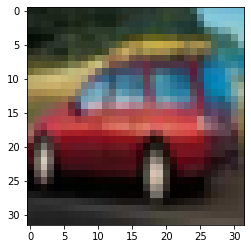

In [4]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [5]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))


Filter weights: [[[[-0.8418886  -1.1818614 ]
   [-0.82231194  0.6745815 ]
   [-0.5633994  -0.7343026 ]]]]
Conv output: [[[[-0.23758714 -0.22885145 -0.20043497 ... -1.4829187  -1.4587424
    -1.4488126 ]
   [-0.324944   -0.2780408  -0.28779182 ... -1.5462024  -1.5318023
    -1.5230666 ]
   [-0.33367968 -0.28126556 -0.33147028 ... -1.5865554  -1.5732725
    -1.5559031 ]
   ...
   [-0.38437018 -0.3668988  -0.3668988  ... -0.528536   -0.53727174
    -0.56347877]
   [-0.3232204  -0.30574903 -0.30574903 ... -0.58095014 -0.5722145
    -0.5722145 ]
   [-0.28827766 -0.27954197 -0.28827766 ... -0.7032498  -0.6945141
    -0.66830707]]

  [[-0.09129092 -0.08642197 -0.06893551 ... -0.67755294 -0.651896
    -0.6386224 ]
   [-0.13998045 -0.1182811  -0.11762501 ... -0.7164072  -0.6894635
    -0.6845946 ]
   [-0.14484939 -0.11563568 -0.14196977 ... -0.74591994 -0.72010076
    -0.7170124 ]
   ...
   [-0.21423385 -0.20449594 -0.20449594 ... -0.30769905 -0.312568
    -0.32717484]
   [-0.1801512  -0.170413

Showing that coding a convolution from scratch that takes in the original image and initial weights used by Objax's convolution (Conv2d.w.value). 

In [6]:
## 1.2 My convolution

def my_conv_net(my_image, initial_filter_weights):
  ## my_image: 1x3x32x32 numpy array representing a 32x32 RGB image with batch size  of 1
  ## initial_filter_weights: 3x2 numpy array representing weights of the filter

  k = 1 #kernel size is 1 therefore can directly encode it into the loops as 0s
  c_in = 3 # channel input size
  c_out = 2 # channel output size

  conv_output = np.zeros((1, c_out , my_image.shape[2], my_image.shape[3])) # initialize output
  for c in range(c_out): # for each 1 of the 2 channels
    for t in range(c_in): # for each 3 inputs
      for i in range(my_image.shape[2]): # kernel is 1x1 in this case
        for j in range(my_image.shape[3]):
          # adding multiplications of the image with the initial filter weights
          conv_output[0][c][i][j] += np.multiply(my_image[0][t][i][j], initial_filter_weights[0][0][t][c])
  return conv_output

Conv2d = my_conv_net(my_image, filter_weights)
print("Filter weights:", filter_weights)
print("Conv output:", Conv2d)
print("Conv output shape:", np.shape(Conv2d))

Filter weights: [[[[-0.8418886  -1.1818614 ]
   [-0.82231194  0.6745815 ]
   [-0.5633994  -0.7343026 ]]]]
Conv output: [[[[-0.23758712 -0.22885144 -0.20043497 ... -1.48291872 -1.45874235
    -1.4488126 ]
   [-0.32494398 -0.2780408  -0.28779183 ... -1.5462024  -1.53180223
    -1.52306655]
   [-0.33367967 -0.28126555 -0.33147026 ... -1.58655535 -1.57327249
    -1.55590306]
   ...
   [-0.38437018 -0.36689881 -0.36689881 ... -0.52853603 -0.53727171
    -0.56347877]
   [-0.32322038 -0.30574901 -0.30574901 ... -0.58095014 -0.57221446
    -0.57221446]
   [-0.28827764 -0.27954195 -0.28827764 ... -0.70324975 -0.69451406
    -0.668307  ]]

  [[-0.09129093 -0.08642198 -0.06893551 ... -0.67755295 -0.65189602
    -0.63862242]
   [-0.13998043 -0.1182811  -0.11762501 ... -0.71640716 -0.68946351
    -0.68459456]
   [-0.14484939 -0.11563568 -0.14196977 ... -0.74591992 -0.72010075
    -0.71701237]
   ...
   [-0.21423384 -0.20449593 -0.20449593 ... -0.30769904 -0.31256799
    -0.32717484]
   [-0.18015118

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [7]:
#Check that .mean((2,3)) rearranges your image
rearranged = Conv2d.mean((2,3))
print(rearranged)

[[-0.66391743 -0.40267415]]


Feeding the rearranged output into a linear layer of appropriate size.
Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.



In [8]:
## Objax's linear layer output
lin_layer = objax.nn.Linear(2, 1)
Y = lin_layer(rearranged)
w = lin_layer.w.value
b = lin_layer.b.value

print('Objax\'s linear layer is: ', Y)
print('w value is:', w)
print('b value is:', b)

## 1.3 my linear layer implementation
my_lin_layer = np.dot(rearranged, w) + b
print('My linear layer is: ', my_lin_layer)
print('My linear layer gives the same output as Objax\'s')

Objax's linear layer is:  [[0.01135264]]
w value is: [[ 0.00710924]
 [-0.03991463]]
b value is: [0.]
My linear layer is:  [[0.01135264]]
My linear layer gives the same output as Objax's


## Part 2. Training and Tuning a CNN

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. 

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

### Difference between training and validation set
We use the training set to train our parameters like weights and bias for the model, whereas the validation set is used to tune the hyperparameters of our model given the parameters which were converged to by the training set. The validation set is necessary as we want to be able to get the optimal generalizability of the model, where validation allows us to pick the best hyperparameters to do so.

A data set is therefore split into 3 sections, where the training and validation tune parameters and hyperparameters, and the test set measures generalizability of the model. 


### Training

In [11]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad ## 2.1 <------------------------------------------------------------------------
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [12]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2 <------------------------------------------------------------------
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2 <--------------------------------------------------------------------
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 10.34 Validation Accuracy 10.50
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.42 Validation Accuracy 10.88
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.07 Validation Accuracy 11.63
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.89 Validation Accuracy 12.77
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 13.26 Validation Accuracy 12.58
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.76 Validation Accuracy 12.73
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.84 Validation Accuracy 13.08
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 12.90 Validation Accuracy 14.18
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.39 Validation Accuracy 14.18
Epoch 0010  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 13.94 Valida

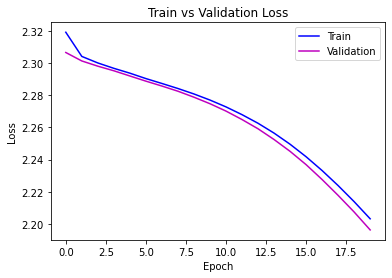

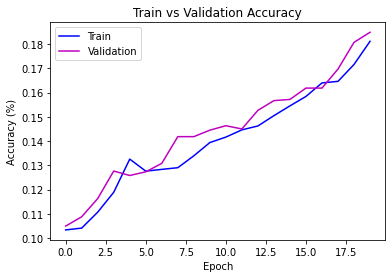

In [ ]:
train()

### Hyperparameters
A hyperparameter is a parameter you cannot adjust or include within the training of the model, where they are tuned by the validation set after training.

Importance of tuning hyperparameters:
Tuning hyperparameters using a validation set allows the model to have the most optimal set of hyperparameters to minimize the loss function. Thus, hyperparameters control the behavior of the model and significantly influence the final results when we run the model on a test set. If we do not tune the hyperparameters, we are not ensuring the most optimal results when we run the model with the test set. 

### Selecting Hyperparameters

I have chosen the 4 parameters to be 
$H =$ {batch size, learning rate, epochs, k} where kernels change the CNN architecture.

*   Base Model: {32, 0.0009, 20, 2}
*   $H_1 =$ {64, 0.005, 30, 4}
*   $H_2 = ${16, 0.01, 25, 6}




### 2 New Models


#### Model 1

In [ ]:
## 2.6 First model with hyperparameters H1
class ConvNet1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 4), objax.functional.relu]) # changed k=4
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 4), objax.functional.relu]) # changed k=4
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # convolution then max pooling layer
    x = self.conv_2(x) 
  
    x = x.mean((2,3)) # global average pooling s
    x = self.linear(x) # fully connected layer
    return x

#Create the CNN
model_1 = ConvNet1()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_1(x)), model_1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad ## 2.1
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 12.23 Validation Accuracy 12.45
Epoch 0002  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 14.90 Validation Accuracy 14.70
Epoch 0003  Training Loss 2.25 Validation Loss 2.23 Training Accuracy 16.76 Validation Accuracy 17.03
Epoch 0004  Training Loss 2.20 Validation Loss 2.16 Training Accuracy 19.75 Validation Accuracy 22.75
Epoch 0005  Training Loss 2.13 Validation Loss 2.09 Training Accuracy 24.40 Validation Accuracy 25.50
Epoch 0006  Training Loss 2.07 Validation Loss 2.05 Training Accuracy 26.44 Validation Accuracy 25.92
Epoch 0007  Training Loss 2.03 Validation Loss 2.02 Training Accuracy 27.46 Validation Accuracy 28.07
Epoch 0008  Training Loss 2.01 Validation Loss 1.99 Training Accuracy 28.52 Validation Accuracy 26.48
Epoch 0009  Training Loss 1.98 Validation Loss 1.96 Training Accuracy 28.93 Validation Accuracy 29.17
Epoch 0010  Training Loss 1.95 Validation Loss 1.94 Training Accuracy 30.10 Valida

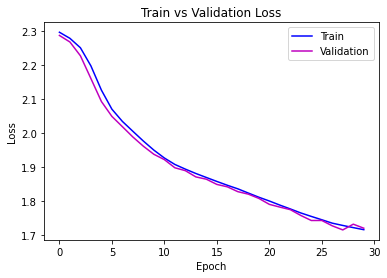

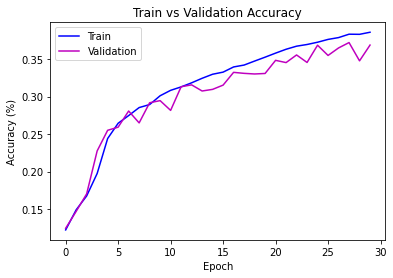

In [ ]:
train1(EPOCHS=30, BATCH = 64, LEARNING_RATE = 0.005)

#### Model 2


In [13]:
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 6), objax.functional.relu]) # changed k=6
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 6), objax.functional.relu]) # changed k=6
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) # convolution then max pooling layer
    x = self.conv_2(x) # convolution - tanh function
  
    x = x.mean((2,3)) # global average pooling 
    x = self.linear(x) # fully connected layer
    return x

#create the CNN
model_2 = ConvNet2()

In [14]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_2(x)), model_2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad ## 2.1
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [15]:
def train2(EPOCHS=25, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.07 Validation Loss 1.88 Training Accuracy 28.24 Validation Accuracy 31.62
Epoch 0002  Training Loss 1.87 Validation Loss 1.82 Training Accuracy 37.29 Validation Accuracy 31.42
Epoch 0003  Training Loss 1.76 Validation Loss 1.74 Training Accuracy 41.69 Validation Accuracy 32.70
Epoch 0004  Training Loss 1.69 Validation Loss 1.66 Training Accuracy 44.32 Validation Accuracy 38.07
Epoch 0005  Training Loss 1.64 Validation Loss 1.64 Training Accuracy 45.86 Validation Accuracy 38.72
Epoch 0006  Training Loss 1.60 Validation Loss 1.58 Training Accuracy 47.64 Validation Accuracy 42.53
Epoch 0007  Training Loss 1.56 Validation Loss 1.51 Training Accuracy 49.29 Validation Accuracy 44.67
Epoch 0008  Training Loss 1.53 Validation Loss 1.49 Training Accuracy 50.85 Validation Accuracy 44.10
Epoch 0009  Training Loss 1.49 Validation Loss 1.45 Training Accuracy 52.21 Validation Accuracy 47.43
Epoch 0010  Training Loss 1.46 Validation Loss 1.48 Training Accuracy 53.65 Valida

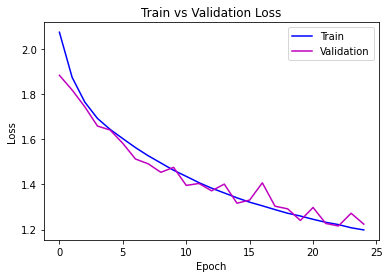

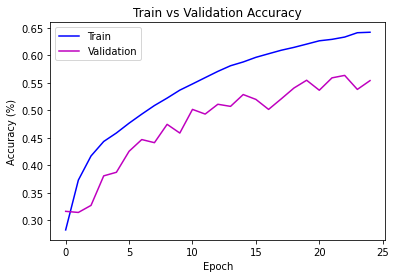

In [16]:
train2(EPOCHS=25, BATCH = 16, LEARNING_RATE = 0.01)

### Validation Accuracy

*   Base model: 18.48% at epoch 20
*   Model 1: 37.18% at epoch 28
*   Model 2: 56.33% at epoch 23

The model to pick as the final model is Model 2 as it demonstrated the highest validation accuracy. This means that Model 2 performs better than Model 1 when compared to the predictions.

### Testing the CNN

Testing the CNN with the hyperparameters of Model 2 and the test set.

In [17]:
def test(EPOCHS=25, BATCH = 16, LEARNING_RATE = 0.01):
    # run test set
    test_acc = 0       # testing accuracy per batch
    test_indices = np.arange(len(X_test)) 
    np.random.shuffle(test_indices)

    for it in range(0, X_test.shape[0], BATCH):
        batch = test_indices[it: it+BATCH] ## 2.2
        test_prediction = predict(X_test[batch]).argmax(1)
        test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
    print('Testing Accuracy %.2f' % (100*test_acc/X_test.shape[0]))


In [18]:
test()

Testing Accuracy 56.10


## Part 3. Trying Out a New Dataset

The selected dataset was the [fashion mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset in Tensorflow 

### Import and partitioning data

In [36]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = np.expand_dims(X_train, 1)
X_train = np.asarray(X_train, dtype= np.float32) #changes datatype to float 
#X_train = X_train.transpose(0, 3, 1, 2) / 255.0 #
Y_train = Y_train.flatten()
#X_test = X_test.transpose(0, 3, 1, 2) / 255.0
X_test = np.expand_dims(X_test, 1)
X_test = np.asarray(X_test, dtype= np.float32)
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

### Base Model

In [41]:
class ConvNetFashion(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10): #changed to 1 channel instead of 3
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) # global average pooling 
    x = self.linear(x) #fully connected layer
    return x

#The following line creates the CNN
fashion_model = ConvNetFashion()

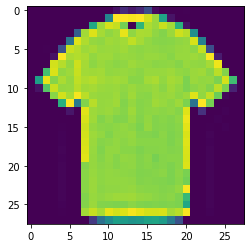

In [32]:
#plot the first image in the training set.
plt.imshow(X_train[0][0])

In [42]:
#Define loss function as averaged value of of cross entropies
def loss_function_fm(x, labels):
    logit = fashion_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(fashion_model(x)), fashion_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function_fm, fashion_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in fashion_model.vars().subset(objax.TrainVar))

#Training routine
def train_op_fm(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad 
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op_fm = objax.Jit(train_op_fm, gv.vars() + tv.vars())

In [43]:
def train(EPOCHS = 10, BATCH = 64, LEARNING_RATE = 0.05):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2
          avg_train_loss += float(train_op_fm(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2
          avg_val_loss += float(loss_function_fm(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.14 Validation Loss 1.21 Training Accuracy 66.57 Validation Accuracy 56.43
Epoch 0002  Training Loss 0.99 Validation Loss 0.98 Training Accuracy 69.68 Validation Accuracy 63.61
Epoch 0003  Training Loss 0.97 Validation Loss 0.97 Training Accuracy 70.27 Validation Accuracy 65.97
Epoch 0004  Training Loss 0.95 Validation Loss 0.90 Training Accuracy 70.91 Validation Accuracy 69.20
Epoch 0005  Training Loss 0.93 Validation Loss 0.86 Training Accuracy 71.79 Validation Accuracy 70.81
Epoch 0006  Training Loss 0.91 Validation Loss 0.88 Training Accuracy 71.97 Validation Accuracy 68.83
Epoch 0007  Training Loss 0.89 Validation Loss 0.83 Training Accuracy 72.81 Validation Accuracy 71.37
Epoch 0008  Training Loss 0.88 Validation Loss 0.93 Training Accuracy 72.97 Validation Accuracy 67.47
Epoch 0009  Training Loss 0.86 Validation Loss 0.88 Training Accuracy 73.54 Validation Accuracy 68.37
Epoch 0010  Training Loss 0.85 Validation Loss 0.81 Training Accuracy 73.69 Valida

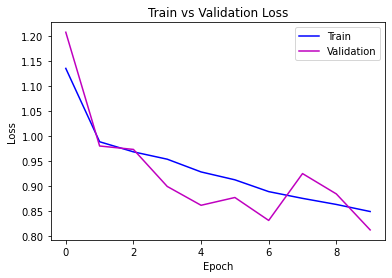

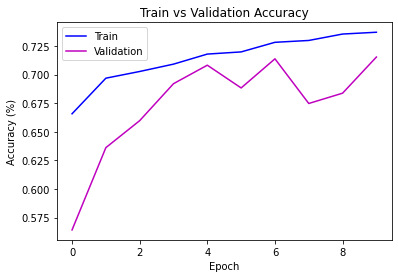

In [ ]:
train(EPOCHS = 10, BATCH = 64, LEARNING_RATE = 0.05) #base model

Hyperparameters to tune: epochs, batch size, learning rate

Epoch 0001  Training Loss 1.70 Validation Loss 1.03 Training Accuracy 60.47 Validation Accuracy 63.06
Epoch 0002  Training Loss 0.94 Validation Loss 0.84 Training Accuracy 73.22 Validation Accuracy 71.71
Epoch 0003  Training Loss 0.83 Validation Loss 0.78 Training Accuracy 76.03 Validation Accuracy 73.19
Epoch 0004  Training Loss 0.77 Validation Loss 0.72 Training Accuracy 77.75 Validation Accuracy 75.56
Epoch 0005  Training Loss 0.74 Validation Loss 0.71 Training Accuracy 79.10 Validation Accuracy 75.70
Epoch 0006  Training Loss 0.71 Validation Loss 0.67 Training Accuracy 79.98 Validation Accuracy 76.49
Epoch 0007  Training Loss 0.68 Validation Loss 0.65 Training Accuracy 80.64 Validation Accuracy 77.64
Epoch 0008  Training Loss 0.67 Validation Loss 0.63 Training Accuracy 81.18 Validation Accuracy 78.41
Epoch 0009  Training Loss 0.65 Validation Loss 0.67 Training Accuracy 81.84 Validation Accuracy 75.71
Epoch 0010  Training Loss 0.63 Validation Loss 0.64 Training Accuracy 82.29 Valida

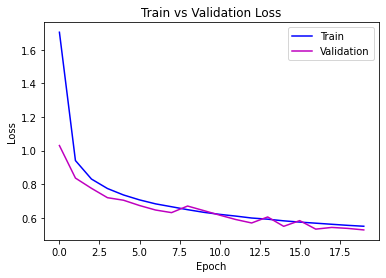

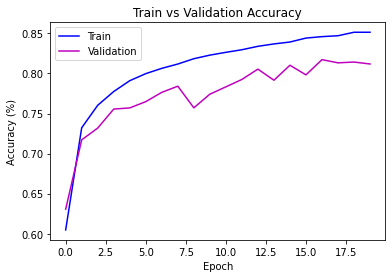

In [44]:
train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.005)

The hyperparameters that I tuned were batch size, epochs, and the learning rate. In the process of tuning, I discovered the various effects of each hyperparameter. One thing I found was that the accuracy is very sensitive to batch size, where a lower batch size often leads to higher accuracy; comparing  the base model with a larger batch size of 100 would gave me much lower validation accuracy. On the other hand, the higher the epochs, the higher the validation accuracy, although it stagnates after a while. Lastly, experimenting with the learning rate showed that a rate too high and too low leads to lower validation accuracy. 

Base model: 71.53 at epoch 10     Final model: 81.43 at epoch 19

In [45]:
def test_fm(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
    # run test set
    test_acc = 0       # testing accuracy per batch
    test_indices = np.arange(len(X_test)) 
    np.random.shuffle(test_indices)

    for it in range(0, X_test.shape[0], BATCH):
        batch = test_indices[it: it+BATCH] ## 2.2
        test_prediction = predict(X_test[batch]).argmax(1)
        test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
    print('Testing Accuracy %.2f' % (100*test_acc/X_test.shape[0]))

In [46]:
test_fm()

Testing Accuracy 80.57


## Problem 4. Open-Ended Exploration

**Selected problem:** additional hyperparameter tuning (1)

I have decided to tune the hyperparameters: activation function, batch size

Using the same fashion_mnist dataset from Tensorflow:


*   Base model: ReLU with batch size 32
*   Final model: softplus with batch size 16

All other hyperparameters were kept constant.


### Base Model

In [ ]:
# Define a new convolution
class ConvNetExplorationBase(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu]) #channels
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x) #fully connected layer
    return x

#The following line creates the CNN
base_model = ConvNetExplorationBase()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = base_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(base_model(x)), base_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, base_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in base_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad ## 2.1
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train_base(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.67 Validation Loss 1.10 Training Accuracy 54.14 Validation Accuracy 61.40
Epoch 0002  Training Loss 1.06 Validation Loss 1.00 Training Accuracy 69.36 Validation Accuracy 65.20
Epoch 0003  Training Loss 0.96 Validation Loss 0.89 Training Accuracy 73.27 Validation Accuracy 70.23
Epoch 0004  Training Loss 0.90 Validation Loss 0.84 Training Accuracy 74.82 Validation Accuracy 72.27
Epoch 0005  Training Loss 0.86 Validation Loss 0.80 Training Accuracy 75.74 Validation Accuracy 72.66
Epoch 0006  Training Loss 0.83 Validation Loss 0.77 Training Accuracy 76.63 Validation Accuracy 74.33
Epoch 0007  Training Loss 0.80 Validation Loss 0.75 Training Accuracy 77.26 Validation Accuracy 74.71
Epoch 0008  Training Loss 0.79 Validation Loss 0.75 Training Accuracy 77.93 Validation Accuracy 75.13
Epoch 0009  Training Loss 0.77 Validation Loss 0.74 Training Accuracy 78.35 Validation Accuracy 74.97
Epoch 0010  Training Loss 0.75 Validation Loss 0.77 Training Accuracy 78.58 Valida

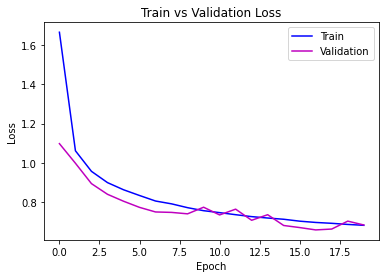

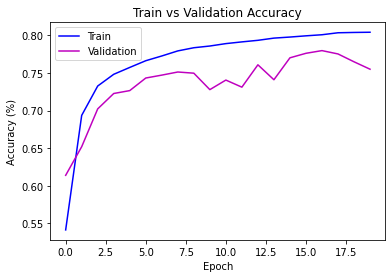

In [ ]:
train_base()

### Discussion
First, I compared the various activation functions by training models with all other hyperparameters constant. The table below displays a comparison of their maximum validation accuracies with batch size 32. Since the prediction function uses the softmax activation function, I decided not to use softmax as a potential activation function to test.

| Activation Function | Validation Accuracy |
| --- | ----------- |
| ReLU | 77.97 at epoch 17 |
| Sigmoid | 31.70 at epoch 20 |
|tanh | 51.60 at epoch 20|
| softplus | 82.04 at epoch 11|

Since the base case uses the ReLU activation function, it was not considered for the final model. Thus, the softplus activation function was chosen as it demonstrated the highest validation accuracy. 

A similar process was done to determine a batch size. Keeping the activation function and all other hyperparameters constant yielded that a lower batch size led to higher validation accuracies. This was determined by taking the batch size as 16, 32, 64, and 100, comparing their maximum validation accuracy.

Therefore, the final model was decided to utilize the softplus activation function with a batch size of 16.

### Final Model

In [ ]:
# Define a new convolution
class ConvNetExplorationFinal(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.softplus]) #changed to sigmoid function
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.softplus]) 
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x): #forward pass 
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) # global average pooling 
    x = self.linear(x) #fully connected layer
    return x

#The following line creates the CNN
final_model = ConvNetExplorationFinal()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = final_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(final_model(x)), final_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, final_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in final_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad ## 2.1
     
    return loss_value # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train_final(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] ## 2.2
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] ## 2.2
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch,color='blue', label="Train")
  plt.plot(avg_val_loss_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, color = 'blue', label="Train")
  plt.plot(val_acc_epoch, color='m', label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.35 Validation Loss 1.04 Training Accuracy 63.46 Validation Accuracy 64.96
Epoch 0002  Training Loss 0.97 Validation Loss 0.91 Training Accuracy 74.86 Validation Accuracy 69.27
Epoch 0003  Training Loss 0.87 Validation Loss 0.82 Training Accuracy 77.71 Validation Accuracy 72.20
Epoch 0004  Training Loss 0.81 Validation Loss 0.75 Training Accuracy 79.19 Validation Accuracy 75.07
Epoch 0005  Training Loss 0.77 Validation Loss 0.72 Training Accuracy 79.91 Validation Accuracy 75.76
Epoch 0006  Training Loss 0.75 Validation Loss 0.71 Training Accuracy 80.51 Validation Accuracy 76.16
Epoch 0007  Training Loss 0.73 Validation Loss 0.69 Training Accuracy 80.76 Validation Accuracy 76.54
Epoch 0008  Training Loss 0.71 Validation Loss 0.67 Training Accuracy 81.15 Validation Accuracy 76.89
Epoch 0009  Training Loss 0.69 Validation Loss 0.67 Training Accuracy 81.63 Validation Accuracy 77.01
Epoch 0010  Training Loss 0.68 Validation Loss 0.67 Training Accuracy 81.73 Valida

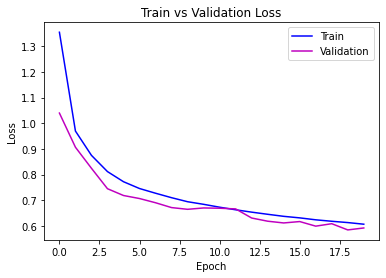

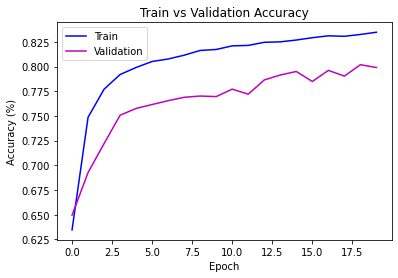

In [ ]:
train_final()

### Testing 

In [ ]:
def test_final(EPOCHS=25, BATCH = 16, LEARNING_RATE = 9e-4):
    # run test set
    avg_test_loss = 0  # (averaged) test loss per batch
    test_acc = 0       # testing accuracy per batch

    test_indices = np.arange(len(X_test)) 
    np.random.shuffle(test_indices)

    for it in range(0, X_test.shape[0], BATCH):
        batch = test_indices[it: it+BATCH] ## 2.2
        avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
        test_prediction = predict(X_test[batch]).argmax(1)
        test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
    print('Testing Accuracy %.2f' % (100*test_acc/X_test.shape[0]))


In [ ]:
test_final()

Testing Accuracy 78.96
